### ***Assignment 2 - Applying convolution networks to image data***

**Download the data**

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"svegiraju","key":"aa21e42941accf19f4a7494676f14fcb"}'}

Upload widget is only available when the cell has been executed in the current browser session. Please rerun this cell to enable.

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats


 98% 799M/812M [00:06<00:00, 145MB/s]
100% 812M/812M [00:06<00:00, 128MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip

In [5]:
!unzip -qq train.zip

In [6]:
!unzip -qq test1.zip

**Q1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?**

**Copying images to training, validation, and test directories**

In [7]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

**Building the model**

Instantiating a small convnet for dogs vs. cats classification

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

Here we have made a model with just four conv2D layers and four maxpooling layers. We have a total of 991,041 parameters.






**Configure the model for training**



In [10]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Data preprocessing** 

Using image_dataset_from_directory to read images

In [11]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [12]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [13]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [14]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [15]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the Dataset**



In [16]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a Dataset**



In [17]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 20s 137ms/step - loss: 0.8033 - accuracy: 0.5295 - val_loss: 0.7004 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 7s 113ms/step - loss: 0.7021 - accuracy: 0.5430 - val_loss: 0.6854 - val_accuracy: 0.5650
Epoch 3/30
63/63 [==============================] - 7s 113ms/step - loss: 0.6921 - accuracy: 0.6155 - val_loss: 0.6677 - val_accuracy: 0.5720
Epoch 4/30
63/63 [==============================] - 7s 113ms/step - loss: 0.6432 - accuracy: 0.6500 - val_loss: 0.6005 - val_accuracy: 0.6900
Epoch 5/30
63/63 [==============================] - 7s 112ms/step - loss: 0.5955 - accuracy: 0.6925 - val_loss: 0.6214 - val_accuracy: 0.6720
Epoch 6/30
63/63 [==============================] - 7s 111ms/step - loss: 0.5587 - accuracy: 0.7205 - val_loss: 0.6166 - val_accuracy: 0.6610
Epoch 7/30
63/63 [==============================] - 7s 111ms/step - loss: 0.5145 - accuracy: 0.7400 - val_loss: 0.6658 - val_accuracy: 0.6350
Epoch

**Displaying curves of loss and accuracy during training**

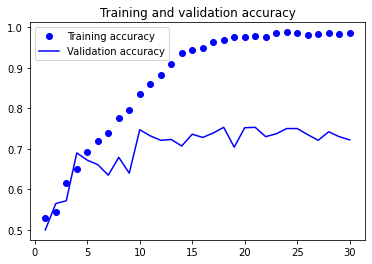

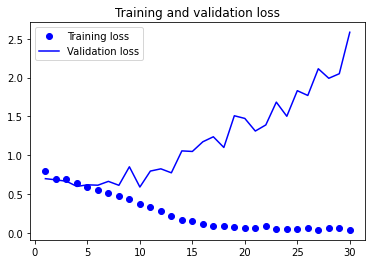

In [18]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**



In [19]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 44ms/step - loss: 0.6490 - accuracy: 0.7200
Test accuracy: 0.720


By running the above model, we have few observations.

1.The model is training very well on the training set to a point after which it starts overfitting.

2.The validation and test accuracy are not at all improving.

So in order to improve our validation andtest accuracy and prevent overfitting, we can use the below three techniques 

a) Data Augmentation

b) Regularization

c) Dropout

Now we will use Data Augmentation to reduce the effects of Overfitting.

**Using Data Augmentation and Dropout**

What do we do in Data Augmentation?

In the simplest sense, we tend to flip, rotate, scale, crop, translate ( moving image along x and y axis), Gaussian Noise (way of distorting high-frequesncy by adding some noise to them).

For our Neural Network, we will only use flipping, rotation and zooming.

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Define a data augmentation stage to add to an image model**

In [21]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

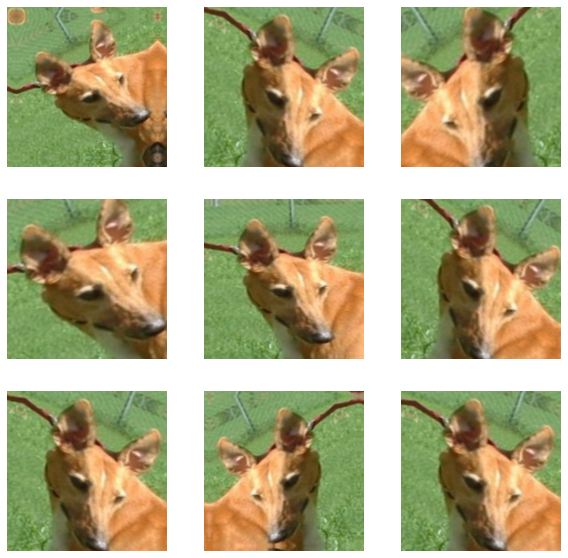

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Here we are showing a sample of 9 images that have been flipped, zoomed and rotated.

**Defining a new convnet that includes image augmentation and dropout**

In [23]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 10s 136ms/step - loss: 0.8259 - accuracy: 0.5060 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 8s 118ms/step - loss: 0.6975 - accuracy: 0.4945 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 8s 118ms/step - loss: 0.6979 - accuracy: 0.5340 - val_loss: 0.6801 - val_accuracy: 0.5530
Epoch 4/50
63/63 [==============================] - 8s 117ms/step - loss: 0.7285 - accuracy: 0.5650 - val_loss: 0.6744 - val_accuracy: 0.5570
Epoch 5/50
63/63 [==============================] - 8s 116ms/step - loss: 0.6799 - accuracy: 0.5820 - val_loss: 0.6829 - val_accuracy: 0.5510
Epoch 6/50
63/63 [==============================] - 8s 116ms/step - loss: 0.6648 - accuracy: 0.6000 - val_loss: 0.6444 - val_accuracy: 0.6250
Epoch 7/50
63/63 [==============================] - 8s 117ms/step - loss: 0.6309 - accuracy: 0.6540 - val_loss: 0.7727 - val_accuracy: 0.6060
Epoch

Here we are training our model again by using data augmentation and dropout. As we are using 2 out of 3 techniques for reducing over fitting, we are going to train it for a little longer as it is gonna take a while for our model to converge.

Here we have also used dropout. Dropout is nothing but ignoring or "dropping out" some of the layers. We basicaly turn off some of the layers during our training.

**Evaluating the model on the test set**

In [25]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 50ms/step - loss: 0.4659 - accuracy: 0.8260
Test accuracy: 0.826


We see that the test accuracy has got improved by using data augmentation and dropout. However, we do have to train the model for more epochs than usual.

**2. Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?**

**Copying images to training, validation, and test directories**

In [26]:
import os, shutil, pathlib

original_dir_2 = pathlib.Path("train")
new_base_dir_2 = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train_2", start_index=0, end_index=2000)
make_subset("validation_2", start_index=2000, end_index=2500)
make_subset("test_2", start_index=2500, end_index=3000)

Here we are increasing our training sampe size to 2000

**Building the model**

**Instantiating a small convnet for dogs vs. cats classification**

In [27]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [28]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

**Configuring the model for training**

In [29]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

**Data preprocessing**

**Using image_dataset_from_directory to read images**

In [30]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train_2",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation_2",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test_2",
    image_size=(180, 180),
    batch_size=32)

Found 4000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [31]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [32]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [33]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [34]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the Dataset**



In [35]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a Dataset**

In [36]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_updated_train_size.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
125/125 [==============================] - 14s 99ms/step - loss: 0.6957 - accuracy: 0.5188 - val_loss: 0.6800 - val_accuracy: 0.5780
Epoch 2/30
125/125 [==============================] - 12s 97ms/step - loss: 0.6867 - accuracy: 0.5430 - val_loss: 0.6865 - val_accuracy: 0.5230
Epoch 3/30
125/125 [==============================] - 12s 97ms/step - loss: 0.6636 - accuracy: 0.6077 - val_loss: 0.6442 - val_accuracy: 0.6490
Epoch 4/30
125/125 [==============================] - 12s 97ms/step - loss: 0.6085 - accuracy: 0.6702 - val_loss: 0.6156 - val_accuracy: 0.6790
Epoch 5/30
125/125 [==============================] - 12s 97ms/step - loss: 0.5528 - accuracy: 0.7215 - val_loss: 0.5459 - val_accuracy: 0.7410
Epoch 6/30
125/125 [==============================] - 12s 97ms/step - loss: 0.4902 - accuracy: 0.7650 - val_loss: 0.5169 - val_accuracy: 0.7490
Epoch 7/30
125/125 [==============================] - 12s 97ms/step - loss: 0.4590 - accuracy: 0.7768 - val_loss: 0.5468 - val_accuracy:

**Displaying curves of loss and accuracy during training**

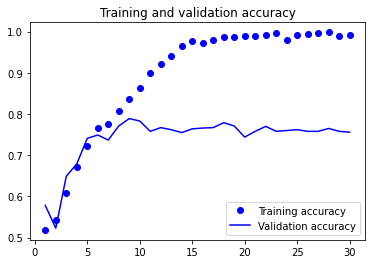

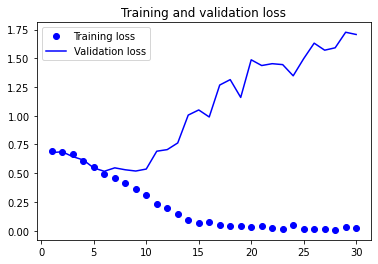

In [37]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [38]:
test_model = keras.models.load_model("convnet_from_scratch_updated_train_size.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 45ms/step - loss: 0.5458 - accuracy: 0.7270
Test accuracy: 0.727


Here we see that we were able to achieve the accuracy of 100% for the training set, but the model didn't perform well for validation and test set.

Now we will use Data Augmentation and Dropout to optimize this network and then observe the acuracies again.

**Using data augmentation and Dropout**

**Define a data augmentation stage to add to an image model**

In [39]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**



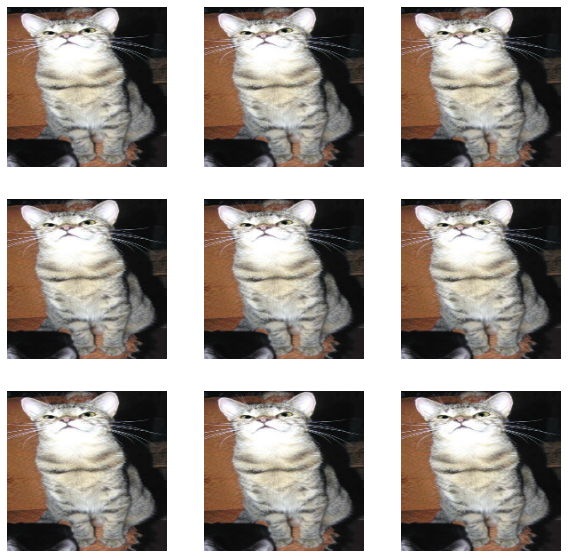

In [40]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Here we are showing a sample of 9 images that have been flipped, zoomed and rotated.

**Defining a new convnet that includes image augmentation and dropout**



In [41]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

**Training the regularized convnet**

In [42]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_updated_train_size_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/25
125/125 [==============================] - 14s 103ms/step - loss: 0.6934 - accuracy: 0.5050 - val_loss: 0.6714 - val_accuracy: 0.5000
Epoch 2/25
125/125 [==============================] - 13s 100ms/step - loss: 0.6829 - accuracy: 0.5433 - val_loss: 0.6911 - val_accuracy: 0.5010
Epoch 3/25
125/125 [==============================] - 13s 101ms/step - loss: 0.6929 - accuracy: 0.5153 - val_loss: 0.6913 - val_accuracy: 0.5090
Epoch 4/25
125/125 [==============================] - 13s 101ms/step - loss: 0.6827 - accuracy: 0.5433 - val_loss: 0.6622 - val_accuracy: 0.5790
Epoch 5/25
125/125 [==============================] - 13s 100ms/step - loss: 0.6873 - accuracy: 0.5485 - val_loss: 0.6842 - val_accuracy: 0.5370
Epoch 6/25
125/125 [==============================] - 13s 101ms/step - loss: 0.6596 - accuracy: 0.6037 - val_loss: 0.6424 - val_accuracy: 0.6340
Epoch 7/25
125/125 [==============================] - 13s 101ms/step - loss: 0.6329 - accuracy: 0.6420 - val_loss: 0.6223 - val_ac

Now we see good improvement already. Firstly, our model is converging at a realy good rate; neither too fast nor too slow. Secondly, train and validation accuracy are moving at almost similar rates.

**Evaluating the model on the test set**

In [43]:
test_model = keras.models.load_model(
    "convnet_from_scratch_updated_train_size_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 43ms/step - loss: 0.4459 - accuracy: 0.7880
Test accuracy: 0.788


Next big improvement that we see is in the test accuracy.

**3. Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.**


**Copying images to training, validation, and test directories**

In [44]:
import os, shutil, pathlib

original_dir_3 = pathlib.Path("train")
new_base_dir_3 = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train_3", start_index=0, end_index=2500)
make_subset("validation_3", start_index=2500, end_index=3000)
make_subset("test_3", start_index=3000, end_index=3500)

**Building the model**


**Instantiating a small convnet for dogs vs. cats classification**

In [45]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [46]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                      

**Configuring the model for training**

In [47]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

**Data preprocessing**

**Using image_dataset_from_directory to read images**

In [48]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train_3",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation_3",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test_3",
    image_size=(180, 180),
    batch_size=32)

Found 5000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [49]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [50]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [51]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [52]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the Dataset**

In [53]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a Dataset**



In [54]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_final.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
157/157 [==============================] - 16s 98ms/step - loss: 0.6835 - accuracy: 0.5344 - val_loss: 0.7030 - val_accuracy: 0.5330
Epoch 2/30
157/157 [==============================] - 15s 92ms/step - loss: 0.6444 - accuracy: 0.6180 - val_loss: 0.6648 - val_accuracy: 0.5970
Epoch 3/30
157/157 [==============================] - 15s 92ms/step - loss: 0.5976 - accuracy: 0.6824 - val_loss: 0.6619 - val_accuracy: 0.6680
Epoch 4/30
157/157 [==============================] - 15s 92ms/step - loss: 0.5605 - accuracy: 0.7056 - val_loss: 0.6251 - val_accuracy: 0.6890
Epoch 5/30
157/157 [==============================] - 15s 92ms/step - loss: 0.5196 - accuracy: 0.7452 - val_loss: 0.5822 - val_accuracy: 0.7170
Epoch 6/30
157/157 [==============================] - 15s 92ms/step - loss: 0.4666 - accuracy: 0.7830 - val_loss: 0.5601 - val_accuracy: 0.7390
Epoch 7/30
157/157 [==============================] - 15s 93ms/step - loss: 0.4176 - accuracy: 0.8104 - val_loss: 0.5422 - val_accuracy:

**Displaying curves of loss and accuracy during training**

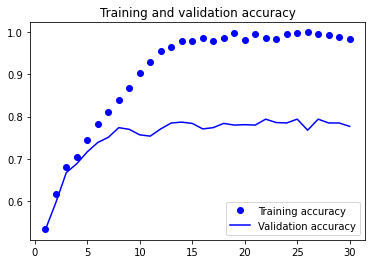

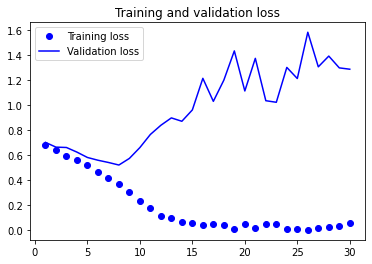

In [55]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [56]:
test_model = keras.models.load_model("convnet_from_scratch_final.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 46ms/step - loss: 0.4250 - accuracy: 0.8110
Test accuracy: 0.811


**Using data augmentation and Dropout**

**Define a data augmentation stage to add to an image model**

In [57]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

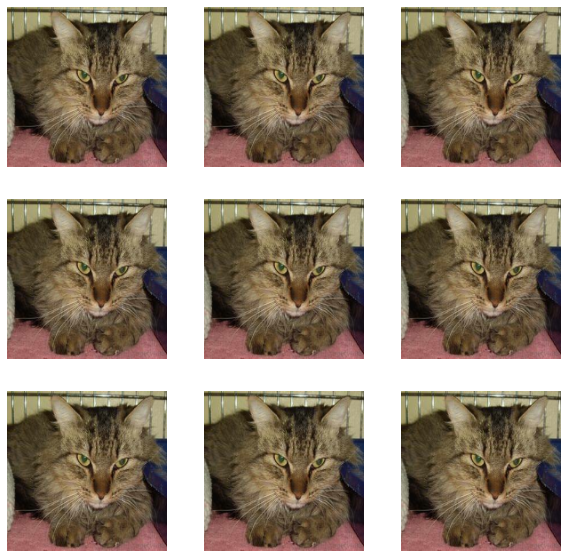

In [58]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Here we are showing a sample of 9 images that have been flipped, zoomed and rotated.

**Defining a new convnet that includes image augmentation and dropout**

In [59]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

**Training the regularized convnet**

In [60]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_final_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=35,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/35
157/157 [==============================] - 17s 99ms/step - loss: 0.6938 - accuracy: 0.5168 - val_loss: 0.6908 - val_accuracy: 0.5110
Epoch 2/35
157/157 [==============================] - 16s 99ms/step - loss: 0.6771 - accuracy: 0.5656 - val_loss: 0.6529 - val_accuracy: 0.6220
Epoch 3/35
157/157 [==============================] - 16s 97ms/step - loss: 0.6547 - accuracy: 0.6124 - val_loss: 0.6771 - val_accuracy: 0.6140
Epoch 4/35
157/157 [==============================] - 16s 98ms/step - loss: 0.6352 - accuracy: 0.6472 - val_loss: 0.6531 - val_accuracy: 0.6500
Epoch 5/35
157/157 [==============================] - 16s 98ms/step - loss: 0.6226 - accuracy: 0.6568 - val_loss: 0.8277 - val_accuracy: 0.5610
Epoch 6/35
157/157 [==============================] - 16s 98ms/step - loss: 0.5974 - accuracy: 0.6836 - val_loss: 0.7469 - val_accuracy: 0.6290
Epoch 7/35
157/157 [==============================] - 16s 98ms/step - loss: 0.5923 - accuracy: 0.6868 - val_loss: 0.5975 - val_accuracy:



By observing the above results it is clear that the training and validation accuracy are running at similar pace. Also, by increasing the number of epochs, we can make our model converge.

**Evaluating the model on the test set**



In [61]:
test_model = keras.models.load_model(
    "convnet_from_scratch_final_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 44ms/step - loss: 0.3218 - accuracy: 0.8650
Test accuracy: 0.865


Here, we see that there is a good improvement in test accuracy.

**4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.**

**Using a pretrained model**

**Instantiating the VGG16 convolutional base**

In [62]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [63]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Here by observing the above summary results, it is very clear that this is a pretty big model with almost 14 Million plus parameters.

**Fast feature extraction without data augmentation**

**Extracting the VGG16 features and corresponding labels**

In [64]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [65]:
train_features.shape

(5000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [66]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
157/157 [==============================] - 2s 7ms/step - loss: 10.2917 - accuracy: 0.9496 - val_loss: 4.8260 - val_accuracy: 0.9730
Epoch 2/20
157/157 [==============================] - 1s 7ms/step - loss: 2.1450 - accuracy: 0.9836 - val_loss: 4.6203 - val_accuracy: 0.9690
Epoch 3/20
157/157 [==============================] - 1s 7ms/step - loss: 0.9936 - accuracy: 0.9910 - val_loss: 8.1148 - val_accuracy: 0.9570
Epoch 4/20
157/157 [==============================] - 1s 7ms/step - loss: 0.6809 - accuracy: 0.9932 - val_loss: 5.3318 - val_accuracy: 0.9730
Epoch 5/20
157/157 [==============================] - 1s 7ms/step - loss: 0.6094 - accuracy: 0.9954 - val_loss: 5.4506 - val_accuracy: 0.9720
Epoch 6/20
157/157 [==============================] - 1s 7ms/step - loss: 0.5074 - accuracy: 0.9954 - val_loss: 5.9231 - val_accuracy: 0.9720
Epoch 7/20
157/157 [==============================] - 1s 7ms/step - loss: 0.7593 - accuracy: 0.9942 - val_loss: 5.7074 - val_accuracy: 0.9760
Epoch

**Plotting the results**

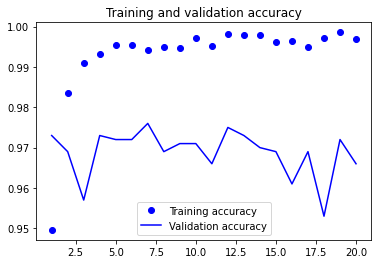

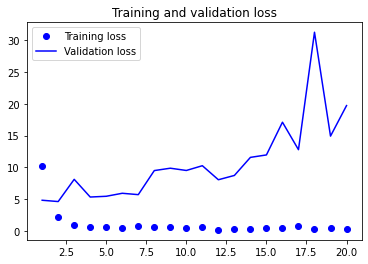

In [67]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

We can clearly see that how well the pretrained model is working. The training and validation accuracy are moving at a similar pace and just by running for 20 epochs, we were able to get an accuracy around 97%.

**Feature extraction together with data augmentation**

**Instantiating and freezing the VGG16 convolutional base**

In [68]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [69]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [70]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [71]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [72]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
157/157 [==============================] - 45s 275ms/step - loss: 9.0204 - accuracy: 0.9266 - val_loss: 6.1302 - val_accuracy: 0.9620
Epoch 2/10
157/157 [==============================] - 43s 273ms/step - loss: 5.5900 - accuracy: 0.9508 - val_loss: 5.9359 - val_accuracy: 0.9640
Epoch 3/10
157/157 [==============================] - 43s 272ms/step - loss: 3.2307 - accuracy: 0.9656 - val_loss: 4.9029 - val_accuracy: 0.9680
Epoch 4/10
157/157 [==============================] - 43s 273ms/step - loss: 2.7917 - accuracy: 0.9686 - val_loss: 3.2722 - val_accuracy: 0.9720
Epoch 5/10
157/157 [==============================] - 43s 272ms/step - loss: 1.7188 - accuracy: 0.9740 - val_loss: 2.6431 - val_accuracy: 0.9720
Epoch 6/10
157/157 [==============================] - 43s 272ms/step - loss: 1.2988 - accuracy: 0.9746 - val_loss: 2.4759 - val_accuracy: 0.9710
Epoch 7/10
157/157 [==============================] - 43s 272ms/step - loss: 1.0775 - accuracy: 0.9744 - val_loss: 2.2564 - val_ac

**Evaluating the model on the test set**

In [73]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 7s 215ms/step - loss: 0.8214 - accuracy: 0.9780
Test accuracy: 0.978


We can see clearly that Data Augmentation is not able to improve our results significantly.So we will try some other technique.

We will fine tune our model by freezing all the layers except for the last 4 and then check our model's accuracy.

# Fine-tuning a pretrained model

In [74]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Freezing all layers until the fourth from the last

In [75]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [76]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
157/157 [==============================] - 50s 303ms/step - loss: 0.3420 - accuracy: 0.9824 - val_loss: 0.9966 - val_accuracy: 0.9700
Epoch 2/10
157/157 [==============================] - 48s 303ms/step - loss: 0.3113 - accuracy: 0.9818 - val_loss: 0.7218 - val_accuracy: 0.9710
Epoch 3/10
157/157 [==============================] - 48s 301ms/step - loss: 0.1938 - accuracy: 0.9822 - val_loss: 0.8852 - val_accuracy: 0.9680
Epoch 4/10
157/157 [==============================] - 48s 303ms/step - loss: 0.1560 - accuracy: 0.9864 - val_loss: 0.6818 - val_accuracy: 0.9720
Epoch 5/10
157/157 [==============================] - 48s 301ms/step - loss: 0.1596 - accuracy: 0.9854 - val_loss: 0.7131 - val_accuracy: 0.9720
Epoch 6/10
157/157 [==============================] - 48s 303ms/step - loss: 0.1349 - accuracy: 0.9858 - val_loss: 0.6206 - val_accuracy: 0.9710
Epoch 7/10
157/157 [==============================] - 48s 301ms/step - loss: 0.0930 - accuracy: 0.9882 - val_loss: 0.6072 - val_ac

In [77]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 7s 214ms/step - loss: 0.4197 - accuracy: 0.9820
Test accuracy: 0.982


By observing the above results it is clear that we were able to push our model a little further by freezing some of it's layers and retraining it on our dataset.

# **What is the relationship between training sample size and choice of network?**

The size of the training sample and the network chosen are important, but only in the context of the conditions in which they are used. When we are building our own model from the scratch, factors like sample size are crucial. By picking up the signals, a large enough training sample aids our model's convergence. In a Pretrained Model, however, we might not need this.

When it comes to Pretrained Model, we already have the weights for that model. All we have to do now is feed it our data and receive the desired output. However, there is a method to make this better. We can freeze some of the model's layers and retrain it with our data such that it performs well with our data.

By freezing some layers, we are keeping the weights of those layers intact. This saves us a significant amount of time and computing power. It would take a lot of time and computational power to train a similar model from scratch, and there's a strong possibility it wouldn't even converge for us. As a result, freezing some layers allows us to completely avoid this problem.

Now we can train the model's final layers, which will allow it to recognize any peculiar signals that are exclusive to our dataset. This will give us a model that performs perfectly well for us on unknown data, and we can even modify it later using the method described above.
